# Training Data Visualizer

In [21]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

%matplotlib inline
import matplotlib.pyplot as plt

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer

from PIL import Image
import cv2
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import matplotlib.cm as cm
from matplotlib.pyplot import subplots

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib
import yaml
from pathlib import Path

zsh:1: command not found: nvcc
torch:  2.3 ; cuda:  2.3.1
detectron2: 0.6


In [22]:
DATA_DIR = Path("../data")

TRAIN_DIR = DATA_DIR / "train"
VAL_DIR = DATA_DIR / "val"
TEST_DIR = DATA_DIR / "test"

CONFIG_FILE = "../configuration.yaml"

In [25]:

def parse_configuration_file(config_file: str) -> tuple:

    with open(config_file, 'r') as f:
            config = yaml.load(f, Loader=yaml.FullLoader)
            info = config['info']
            hyperparameters = config['hyperparameters']

    return (info, hyperparameters)

def construct_dataset_dict(dataset_dir: str, class_dict: dict) -> dict:

    annotations_file = os.path.join(dataset_dir, "annotations.json")
    assert os.path.exists(annotations_file), f"'annotations.json' is missing in the folder: {dataset_dir}"

    with open(annotations_file) as f:
        all_annotations = json.load(f)

    dataset_dicts = []
    for idx, image in enumerate(all_annotations.values()):
        record = {}

        record["file_name"] = os.path.join(dataset_dir, image["filename"])
        record["image_id"] = idx

        annotations = image["regions"]

        objects = []

        for _, annotation in annotations.items():

            regions = annotation["region_attributes"]
            shape_attr = annotation["shape_attributes"]
            px = shape_attr["all_points_x"]
            py = shape_attr["all_points_y"]

            # Filters some weird artifact
            if len(px) >= 100 or len(py) >= 100:
                 continue

            polygon_coords = [(x, y) for x, y in zip(px, py)]
            polygon = [p for x in polygon_coords for p in x]

            category_id = class_dict[regions["label"]]

            object = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [polygon],
                "category_id": category_id,
            }

            objects.append(object)
        
        record["annotations"] = objects
        dataset_dicts.append(record)

    return dataset_dicts

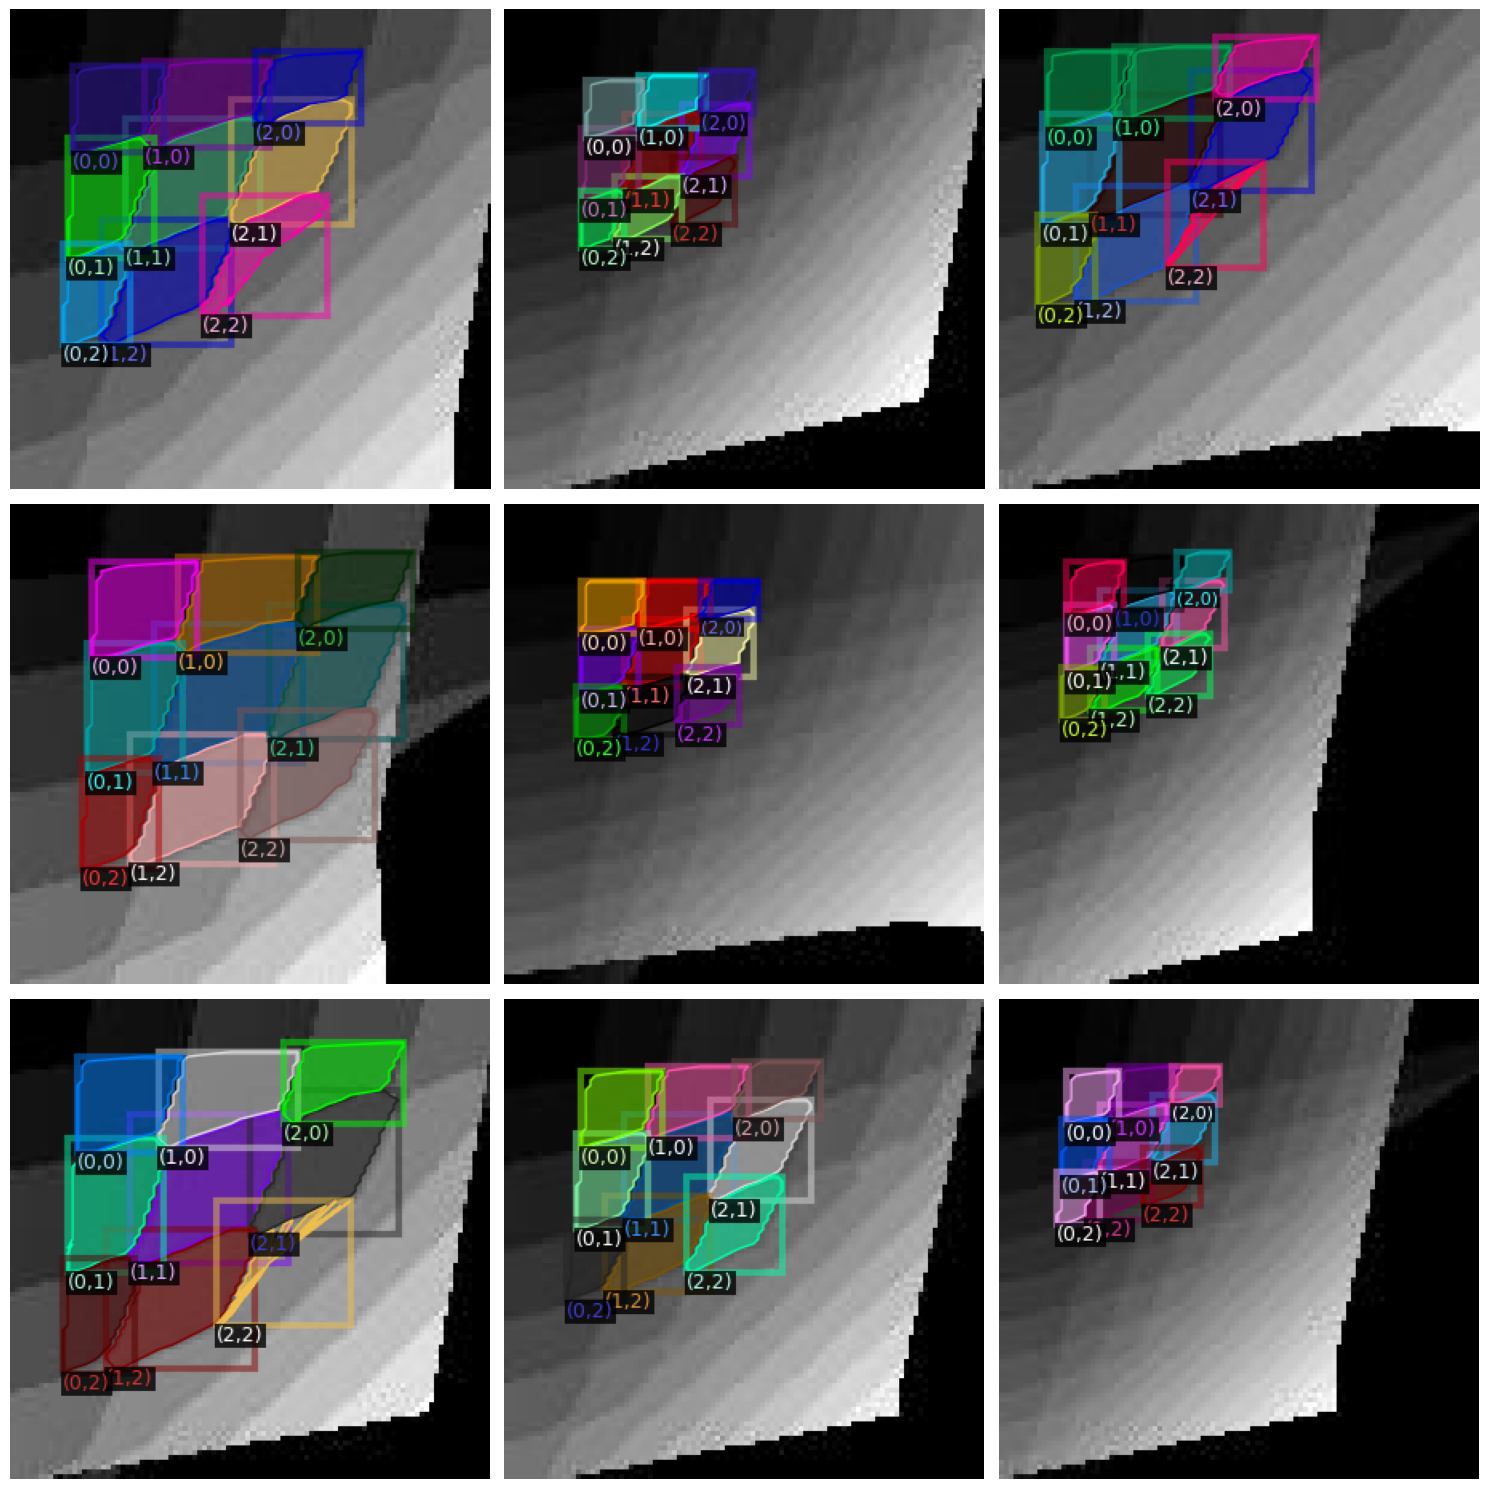

In [29]:
info, hyperparams = parse_configuration_file(CONFIG_FILE)

DatasetCatalog.clear()
MetadataCatalog.clear()

for d in ["train", "val"]:
    DatasetCatalog.register(d, lambda d=d: construct_dataset_dict(DATA_DIR / d, info["classes"]))
    MetadataCatalog.get(d).set(thing_classes=list(info["classes"].keys()))

csd_train_metadata = MetadataCatalog.get("train")
csd_val_metadata = MetadataCatalog.get("val")

# WHICH TO CHECK?
dataset_to_check = "train"

dataset_dir = TRAIN_DIR if dataset_to_check == "train" else VAL_DIR

dataset_dicts = construct_dataset_dict(TRAIN_DIR, info["classes"])

num_of_display_images = 9

num_cols = min(3, num_of_display_images)  # Maximum of 3 columns
num_rows = int(np.ceil(num_of_display_images / num_cols))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

for i, d in enumerate(random.sample(dataset_dicts, num_of_display_images)):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=csd_train_metadata, scale=3)
    out = visualizer.draw_dataset_dict(d)
    if num_rows > 1:
        ax = axs[i // num_cols, i % num_cols]
    else: 
        ax = axs[i % num_cols]
    ax.imshow(out.get_image()[:, :, ::-1])
    ax.axis("off")

plt.tight_layout()
plt.show()

